# Тестирование двойственного алгоритма решения задачи минимизации максимального запаздывания

### Импорты

In [57]:
import time
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit

In [333]:
s = """25,15, 1,59,23,31,24,43,57, 9,44,56,33,48,37,51,49,40,17,16
34,19,45,18,52, 0,21,26, 3,30,35,38, 4,29, 7,53,47,39,27, 5
 8,55,11,54,46,20,41,13,36,22,14,10, 2,28,42, 6,12,32,50,58"""

In [342]:
def parse_str(s):
    s = np.array(s.replace(',', ' ').split(), dtype=int)
    s = s.reshape((len(s)//3, 3))
    return s

In [343]:
SPI = parse_str(s)

In [344]:
SPI

array([[25, 15,  1],
       [59, 23, 31],
       [24, 43, 57],
       [ 9, 44, 56],
       [33, 48, 37],
       [51, 49, 40],
       [17, 16, 34],
       [19, 45, 18],
       [52,  0, 21],
       [26,  3, 30],
       [35, 38,  4],
       [29,  7, 53],
       [47, 39, 27],
       [ 5,  8, 55],
       [11, 54, 46],
       [20, 41, 13],
       [36, 22, 14],
       [10,  2, 28],
       [42,  6, 12],
       [32, 50, 58]])

### Класс "Расписание"

In [226]:
class Schedule:
    """
    A wrap around arrays of shape (n, 3), 
    where n is the number of jobs in the schedule
    and each job parameters are ordered as follows:
    r | p | d
    """
    array = None
    
    def enum(self):
        if len(self.array) > 0:
            a = np.append(self.array, np.ones((len(self.array), 1)), axis=1)
            for i, _ in enumerate(a):
                a[i, 3] += i
            self.array = a.astype(int)
    
    def __init__(self, array, Enumerate=False):
        """
        Arguments:
        - array: int or list/np.ndarray
        if int, the schedule is generated randomly and contains n elements
        if list/np.ndarray/etc., the array is directly transformed into schedule
        """
        if isinstance(array, int):
            self.array = np.random.randint(1, 1000, size=(array, 3))
            self.array[:,2] = self.array[:,2] + self.array[:,1] + self.array[:,0] # for non-negative time slack
        else: self.array = np.copy(array)
        if Enumerate: self.enum()
    
    def show(self):
        print(" r  |  p  |  d  | num ")
        print(self.array)
        
    def sort(self, item=0):
        self.array = self.array[self.array[:,item].argsort()]
        
    def remove(self, B):
        idx = []
        for i, e in enumerate(np.isin(self.array, B)):
            if e.all():
                idx.append(i)
        self.array = np.delete(self.array, idx, axis=0)
    
    def pop(self, index=-1):
        e = self.array[index]
        self.array = np.delete(self.array, index, axis=0)
        return e
    
    def copy(self):
        return Schedule(np.copy(self.array))
    
    def insert(self, index, elem):
        self.array = np.insert(self.array, index, elem, axis=0)
        
    def length(self):
        return self.array.shape[0]
    
    def C(self, j=None):
        t = 0
        for task in self.array[:j]:
            if t < task[0]:
                t = task[0]
            t += task[1]
        return t
    
    def timeshift(self, tau):
        for i in range(self.length()):
            self.array[i,0] -= tau
            
    def L_max(self, tau=0):
        if len(self.array) == 0:
            return float('inf')
        a = self.copy()
        a.timeshift(tau)
        return max([self.C(j+1) - a.array[j,2] for j in range(len(a.array))]) + tau


### Алгоритм решения двойственной задачи

In [266]:
def dual(N, tau, B):
    pi_r = N.copy()
    pi_r.remove(B)
    pi_r.timeshift(tau)
    pi_r.sort()
    bestC = pi_r.C()
    bestI = 0
    # todo: set the condition
    if True:
        for k, e in enumerate(pi_r.array):
            pi_k = pi_r.copy()
            i_k = pi_k.pop(k)
            if pi_k.length() > 0:
                i_l = pi_k.pop(np.argmin(pi_k.array, axis=0)[0])
                pi_k.insert(pi_k.length(), i_k)
                pi_k.insert(0, i_l)
                C_k = pi_k.C()
                if C_k < bestC:
                    print("CH!")
                    bestC = C_k
                    bestI = k
        return bestC + tau, bestI
        

### Класс "пример"
Содержит все параметры примера, указанные в статье: $N,\tau, \nu, \pi, B$, при чём $\nu$ автоматически вычисляется применением двойственного алгоритма к $N$

In [89]:
class Instance:
    
    def __init__(self, N, tau, pi=Schedule([]), B=[]):
        """
        Arguments:
        - N - Schedule object
        - tau - int or (possibly) float
        - pi - Schedule object
        - B - list
        """
        self.N = N.copy()
        self.tau = tau
        self.nu = dual(N, tau, B)[0]
        self.pi = pi.copy()
        self.B = B.copy()
        
    def best_job(self):
        N1 = self.N.copy()
        N1.remove(self.B)
        if len(N1.array) == 0:
            return
        a = N1.array[N1.array[:,0] <= self.tau]
        if len(a) == 0:
            self.tau = np.min(N1.array[:,0], axis=0)
            a = N1.array[N1.array[:,0] <= self.tau]
        f = min(a, key=lambda x: x[2])
        return f

In [107]:
a = Schedule(10).array

In [108]:
a

array([[ 492,  899, 1944],
       [ 924,  111, 1401],
       [ 854,   41,  945],
       [ 593,  386, 1276],
       [ 885,  668, 2232],
       [ 999,  385, 1814],
       [ 546,   36,  833],
       [ 426,  895, 1837],
       [ 796,  713, 1888],
       [ 894,  215, 1725]])

### Алгоритм решения задачи $1|r_j|L_{max}$

In [284]:
# timeout parameter sets maximum calculation time limit in seconds for one schedule
timeout = 1200

def main(N, tau=0):
    #tb = time.time()
    c = 0
    bestPi = Schedule([])    # в алгоритме сказано изначально задать pi* пустым множеством, но ведь тогда его Lateness будет нулём, и это pi* и будет всё время определяться в качетсве оптимального
    instances = [Instance(N, tau)]
    while len(instances) > 0:
        #ti = time.time()
        #if ti - tb > timeout:
        #    return Schedule([]), -1
        index, instance = min(enumerate(instances), key=lambda x: max(x[1].nu, x[1].pi.L_max()) - x[1].pi.length()/N.length()/10)
        f = instance.best_job()
        instances.pop(index)
        if f is not None:

            N1 = instance.N.copy()
            N1.remove(f)
            tau1 = max(f[0], instance.tau) + f[1]
            B1 = []
            a1 = np.copy(instance.pi.array)
            if len(a1) == 0:
                a1 = np.copy([f,])
            else:
                a1 = np.append(a1, [f,], axis=0)
            pi1 = Schedule(a1)
            i1 = Instance(N1, tau1, pi1, B1)

            N2 = instance.N
            tau2 = instance.tau
            if len(instance.B) == 0:
                B2 = np.copy([f,])
            else:
                B2 = np.append(instance.B, [f,], axis=0)
            pi2 = instance.pi
            i2 = Instance(N2, tau2, pi2, B2)

            instances += [i1, i2]
            c += 1
            #pi1.show()
            if pi1.length() == N.length():
                if pi1.L_max(tau) < bestPi.L_max(tau):
                    bestPi = pi1.copy()
            #print("instance nu: %s\ni1 nu: %s\ni2 nu: %s" % (instance.nu, i1.nu, i2.nu))
            #print("Lmax:", bestPi.L_max(tau))
            instances = [i for i in instances if i.nu < bestPi.L_max(tau)]

    return bestPi, c

### Алгоритм перебора *всех* возможных вариантов

In [263]:
def bruteforce(S, tau=0):
    N = np.copy(S.array)
    best_L = Schedule(N).L_max(tau)
    best_S = N
    for p in permutations(N):
        L = Schedule(p).L_max(tau)
        if L < best_L:
            best_L = L
            best_S = p
    return Schedule(best_S)

In [232]:
s = Schedule(SPI, Enumerate=True)
s.show()
s.L_max(0)

 r  |  p  |  d  | num 
[[  23  972 1069    1]
 [ 546  387 1164    2]
 [ 725  365 1368    3]
 [ 950  343 1400    4]
 [ 116  512 1405    5]
 [ 967  751 2325    6]
 [ 797  787 1843    7]]


2297

In [234]:
print(bruteforce(s, 0).L_max(0))
print(p.L_max(0))

1815
1815


In [229]:
n

22

In [233]:
p, n = main(s, 0)

In [235]:
p.L_max(0)

1815

# Тестирование

### Подсчёт корректности работы алгоритма на примерах малой размерности
**Количество задач в примере:** от 2 до 5

**Количество примеров каждой размерности:** 1000

При этом решение, предложенное алгоритмом, сравнивается с решением, полученным методом перебора всех возможных вариантов без учёта запрета на прерывания - то есть перебором находится расписание с минимальным запаздыванием, пусть даже в этом расписании и встречаются прерывания

In [285]:
tc = 0 # true counter - when the result is correct
fc = 0 # false counter - when the result is incorrect
xc = []
yc = []
for n in range(2, 16):
    for i in range(50):
        print('\r', i, end='')
        t = 0
        s = Schedule(n)
        result, count = main(s, t)
        result = result.L_max(t)
        realResult = bruteforce(s, t).L_max(t)
        if result == realResult:
            tc += 1
        else:
            fc += 1
    xc.append(n)
    yc.append(tc/(tc + fc)*100)
    print(" --", n, "tasks", end='')
    print("\t Correct: %d%%\tIncorrect: %d%%" % (tc/(tc + fc)*100, fc/(tc + fc)*100))
    tc = 0
    fc = 0
rresults = [xc, yc]
json.dump(rresults, open('rresults1112.json', 'w'))

 49 -- 2 tasks	 Correct: 88%	Incorrect: 12%
 49 -- 3 tasks	 Correct: 72%	Incorrect: 28%
 49 -- 4 tasks	 Correct: 74%	Incorrect: 26%
 49 -- 5 tasks	 Correct: 68%	Incorrect: 32%
 49 -- 6 tasks	 Correct: 96%	Incorrect: 4%
 49 -- 7 tasks	 Correct: 98%	Incorrect: 2%
 49 -- 8 tasks	 Correct: 96%	Incorrect: 4%
 49 -- 9 tasks	 Correct: 100%	Incorrect: 0%
 49 -- 10 tasks	 Correct: 100%	Incorrect: 0%
 6

KeyboardInterrupt: 

In [286]:
rresults = [xc, yc]
json.dump(rresults, open('rresults1112.json', 'w'))

### Оценка сложности алгоритма
Метрика - количество узлов ветвления

**Размерность примеров:** от 2 до 11

**Количество примеров каждой размерности:** 3, при этом учитываются только примеры, удовлетворяющие критериям:
1. Решение должно быть найдено за время не более 1200 секунд
2. Решение должно быть корректным: отбрасываются те 39% вариантов, решение которых находится за n ветвлений, где n -- размерность примера. Как показало изучение работы алгоритма, именно эти варианты решаются им некорректно из-за того, что $L_{max}$ случайно упорядоченного набора заданий оказывается меньше любого $\nu'$

In [290]:
json.dump(results, open('results777nsew.json', 'w'))

In [315]:
results2 = json.load(open("results55nsew.json", 'r'))

In [289]:
results = dict()
for n in range(10, 101, 5):
    results[n] = []
    for i in range(10):
        print('\r', len(results[n]), end='')
        t = 0
        s = Schedule(n)
        result, count = main(s, t)
        results[n].append(count)
    print(" --", n, "tasks")
    
    json.dump(results, open('results77new.json', 'w'))

 9 -- 10 tasks
 9 -- 15 tasks
 9 -- 20 tasks
 9 -- 25 tasks
 9 -- 30 tasks
 9 -- 35 tasks
 9 -- 40 tasks
 9 -- 45 tasks
 9 -- 50 tasks
 9 -- 55 tasks
 9 -- 60 tasks
 9 -- 65 tasks
 9 -- 70 tasks
 9 -- 75 tasks
 9 -- 80 tasks
 9 -- 85 tasks
 9 -- 90 tasks
 9 -- 95 tasks
 3

KeyboardInterrupt: 

In [312]:
results

{10: [46, 46, 46, 46, 46, 38, 46, 46, 46, 46],
 15: [106, 106, 106, 106, 106, 106, 106, 106, 93, 106],
 20: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191],
 25: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301],
 30: [436, 436, 436, 436, 436, 436, 436, 436, 436, 436],
 35: [596, 596, 596, 596, 596, 596, 596, 596, 596, 596],
 40: [781, 781, 781, 781, 781, 781, 781, 781, 781, 781],
 45: [991, 991, 991, 991, 991, 991, 991, 991, 991, 991],
 50: [1226, 1226, 1226, 1226, 1226, 1226, 1226, 1226, 1226, 1226],
 55: [1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486],
 60: [1771, 1771, 1771, 1771, 1771, 1771, 1771, 1771, 1771, 1771],
 65: [2081, 2081, 2081, 2081, 2081, 2081, 2081, 2081, 2081, 2081],
 70: [2416, 2416, 2416, 2416, 2416, 2416, 2416, 2416, 2416, 2416],
 75: [2776, 2776, 2776, 2776, 2776, 2776, 2776, 2776, 2776, 2776],
 80: [3161, 3161, 3161, 3161, 3161, 3161, 3161, 3161, 3161, 3161],
 85: [3571, 3571, 3571, 3571, 3571, 3571, 3571, 3571, 3571, 3571],
 90: [4006, 4006, 4

### Экспериментальная оценка производительности

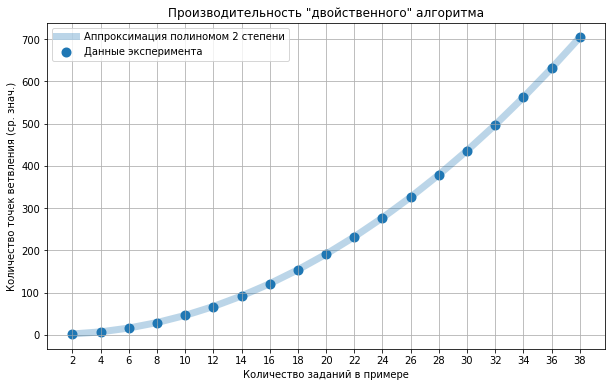

In [328]:
x = []
y = []
#yf = []
for k in results2.keys():
    y.append(np.median(results2[k]))
    x.append(k)
    #yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[i](list(map(int, x))), label='Аппроксимация полиномом %s степени' % (i+1), linewidth=7, alpha=0.3)
ax.legend()

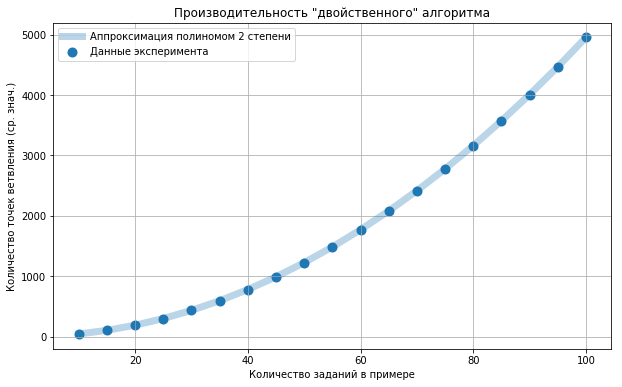

In [311]:
x = []
y = []
yf = []
for k in results.keys():
    y.append(np.median(results[k]))
    x.append(k)
    yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[1](x), label='Аппроксимация полиномом %s степени' % (i+1), linewidth=7, alpha=0.3)
ax.legend()

In [329]:
def approx(x, y, i):
    """
    Parameters:
     - x - x values list
     - y - y values list
     - i - polynome power
    Returns:
     numpy poly1d function
    """
    return np.poly1d(np.polyfit(list(map(float, x)), list(map(float, y)), i))

In [305]:
z[2]

poly1d([ 4.46315329e-18,  5.00000000e-01, -5.00000000e-01,  1.00000000e+00])

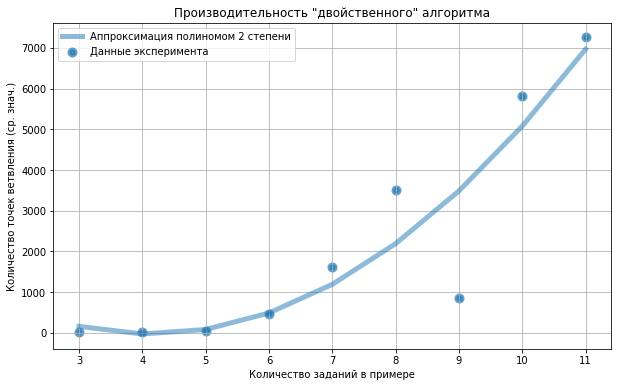

In [46]:
x = []
y = []
yf = []
for k in results.keys():
    if True:
        y.append(np.mean(results[k]))
        x.append(k)
        yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, alpha=0.7, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[i](x), label='Аппроксимация полиномом %s степени' % (i+1), linewidth=5, alpha=0.5)
ax.legend()

Text(0, 0.5, 'Процент верно решённых примеров')

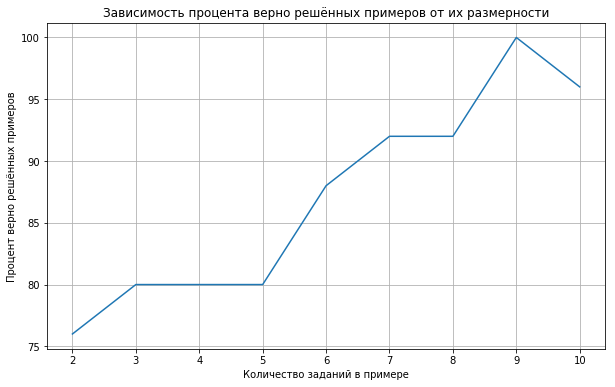

In [272]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Зависимость процента верно решённых примеров от их размерности')
ax.grid()
ax.plot(xc, yc)
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Процент верно решённых примеров")
#ax.plot(x, y, alpha=0.5)

Text(0, 0.5, 'Процент верно решённых примеров')

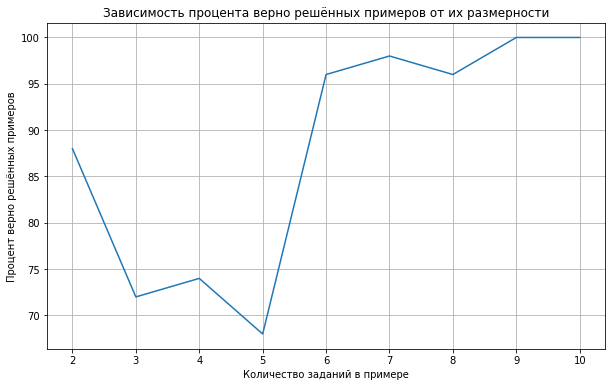

In [288]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Зависимость процента верно решённых примеров от их размерности')
ax.grid()
ax.plot(xc, yc)
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Процент верно решённых примеров")
#ax.plot(x, y, alpha=0.5)

# Итоги и выводы
1. На примерах малой размерности была протестирована корректность работы алгоритма. 61% примеров решаются им правильно.
2. Было оценено быстродействие алгоритма с лимитом времени в 200 секунд. График зависимости процента решённых за 200 секунд примеров от их размерности представлен выше. Всего исследовалось по 50 примеров каждой размерности.
3. Была оценена производительность алгоритма. В качестве метрики использовалось число точек ветвления. Оценивались лишь примеры, решённые за время не более 1200 секунд, и решённые при этом корректно.
4. Все неправильно решённые примеры провоцировали одну и ту же ошибку - по какой-то причине  $L_{max}$ случайно упорядоченного набора заданий оказывался меньше любого $\nu'$, и после подстановки на первое место в $\pi'$ каждого из заданий набора, алгоритм выдавал изначальный вариант расстановки заданий в качестве оптимального расписания.
5. В алгоритме в качестве изначального значения $\pi*$ задавалась случайная последовательность задач, так как если задать $\pi^*=\emptyset$, то это $\pi^*$ и будет оставаться оптимальным из-за того, что его значение $L_{max}=0$